### In this notebook I check out some Strava GIS data and see what plotting the grade on the map would look like.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import folium
import math

In [2]:
#https://www.strava.com/activities/3941493427/analysis 
#- exported with sauce extension: https://saucellc.io

df = pd.read_csv('data/3941493427.csv')
df.head()

,time,distance,lat,lng,altitude
0,59,364.5,50.842853,-1.182159,-1.6
1,60,371.0,50.842849,-1.182251,-1.4
2,61,377.2,50.842845,-1.182340,-1.4
3,62,383.3,50.842838,-1.182425,-1.2
4,63,389.5,50.842833,-1.182513,-1.2


In [3]:
df.columns

Index(['time', ' distance', '       lat', '       lng', ' altitude'], dtype='object')

In [4]:
#fix column names - remove any rogue spaces (probably a little bug in how Sauce extension exports data)
cols = list(df.columns)
newCols = []
for c in cols:
    newCols.append(c.strip(' '))
df.columns = newCols
df.columns

Index(['time', 'distance', 'lat', 'lng', 'altitude'], dtype='object')

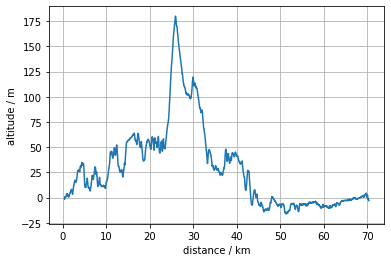

In [5]:
plt.plot(df['distance']/1e3, df['altitude'])
plt.xlabel('distance / km')
plt.ylabel('altitude / m')
plt.grid()

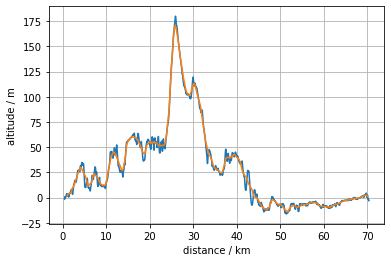

In [6]:
#smooth out altitude with a simple moving average
def SMA(z, l=10):
    z_ = np.ones(len(z)) * np.NaN
    for i in range(len(z) - l):
        z_[i + l//2] = sum(z[i:i+l])/l
    return z_

lag = 60*3 #180 samples ~ 3minutes (not perfect as logger can skip)
df['altitude_smoothed'] = SMA(df['altitude'], lag)
plt.plot(df['distance']/1e3, df['altitude'])
plt.plot(df['distance']/1e3, df['altitude_smoothed'])
plt.xlabel('distance / km')
plt.ylabel('altitude / m')
plt.grid()

<ipython-input-7-4b325010599a>:4: RuntimeWarning: divide by zero encountered in double_scalars
  dz_dD[i] = (z[i+1] - z[i])/(d[i+1] - d[i]) * 100


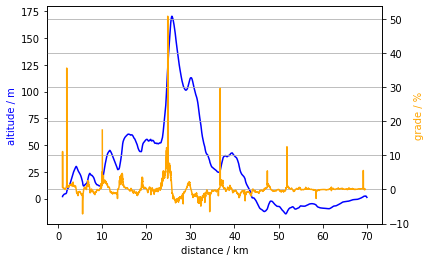

In [7]:
def calc_grade(z, d, l):
    dz_dD = np.ones(len(z)) * np.NaN 
    for i in range(len(z) - l): 
        dz_dD[i] = (z[i+1] - z[i])/(d[i+1] - d[i]) * 100
    return dz_dD
df['grade'] = calc_grade(df['altitude_smoothed'], df['distance'], lag)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df['distance']/1e3, df['altitude_smoothed'], 'blue')
ax2.plot(df['distance']/1e3, df['grade'], 'orange') #Still some outliers. Don't need to worry about outliers for our application

ax1.set_xlabel('distance / km')
ax1.set_ylabel('altitude / m', color='blue')
ax2.set_ylabel('grade / %', color='orange')

plt.grid()
plt.show()

In [8]:
def plot_folium_polyline(df, linecolor):
    points = []
    for i in range(len(df)):
        points.append((df.iloc[i]['lat'],df.iloc[i]['lng']))

    folium.PolyLine(points, color=linecolor, weight=2.5, opacity=1).add_to(m)
    return

m = folium.Map(location=[np.mean(df['lat']),np.mean(df['lng'])], zoom_start=10)
plot_folium_polyline(df, 'red')   
m

### use https://nbviewer.jupyter.org/github/thomashoddinott/ipython-notebooks/blob/master/strava-gis-exploration/nb.ipynb?flush_cache=true to see the rendered map if viewing from github.

(array([ 270.,    0., 7232.,    0.,    0.,  215.,    0.,  363.,    0.,
        1354.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

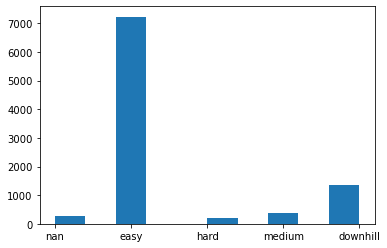

In [9]:
#assign gradient 'categories'
label = []
for i in range(len(df)):
    if df.iloc[i]['grade'] < -1: #these gradients could be nested into plot_color {dict} to make them more programmable. I just picked these arbitrarily.
        label.append('downhill')
    elif df.iloc[i]['grade'] > -1 and df.iloc[i]['grade'] < 3:
        label.append('easy')
    elif df.iloc[i]['grade'] > 3 and df.iloc[i]['grade'] < 6:
        label.append('medium')
    elif df.iloc[i]['grade'] > 6:
        label.append('hard')
    elif math.isnan(df.iloc[i]['grade']): 
        label.append('nan')
        #smoothing the altitude chopped a few samples (lag/2) from each end of the activity.  

df['label'] = label
plt.hist(df['label'])

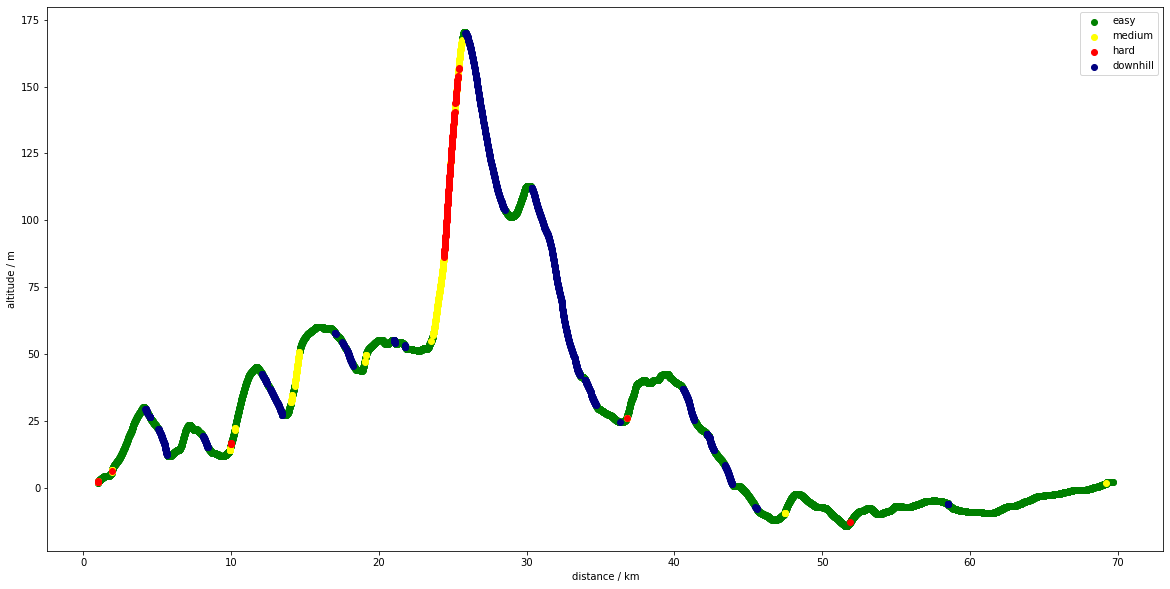

In [10]:
plot_color = {'easy': 'green', 'medium': 'yellow', 'hard': 'red', 'downhill': 'navy'}

def plot_scatter():
    df_easy = df[df['label'] == 'easy']
    df_medium = df[df['label'] == 'medium']
    df_hard = df[df['label'] == 'hard']
    df_downhill = df[df['label'] == 'downhill']

    plt.figure(figsize=[20,10])
    plt.scatter(df_easy['distance']/1e3, df_easy['altitude_smoothed'], label = 'easy', c = plot_color['easy'])
    plt.scatter(df_medium['distance']/1e3, df_medium['altitude_smoothed'], label = 'medium', c = plot_color['medium'])
    plt.scatter(df_hard['distance']/1e3, df_hard['altitude_smoothed'], label = 'hard', c = plot_color['hard'])
    plt.scatter(df_downhill['distance']/1e3, df_downhill['altitude_smoothed'], label = 'downhill', c = plot_color['downhill'])
    plt.xlabel('distance / km')
    plt.ylabel('altitude / m')
    plt.legend()
    return
plot_scatter()

In [11]:
##df[['distance', 'altitude_smoothed', 'label']].to_csv('export_labels.csv')

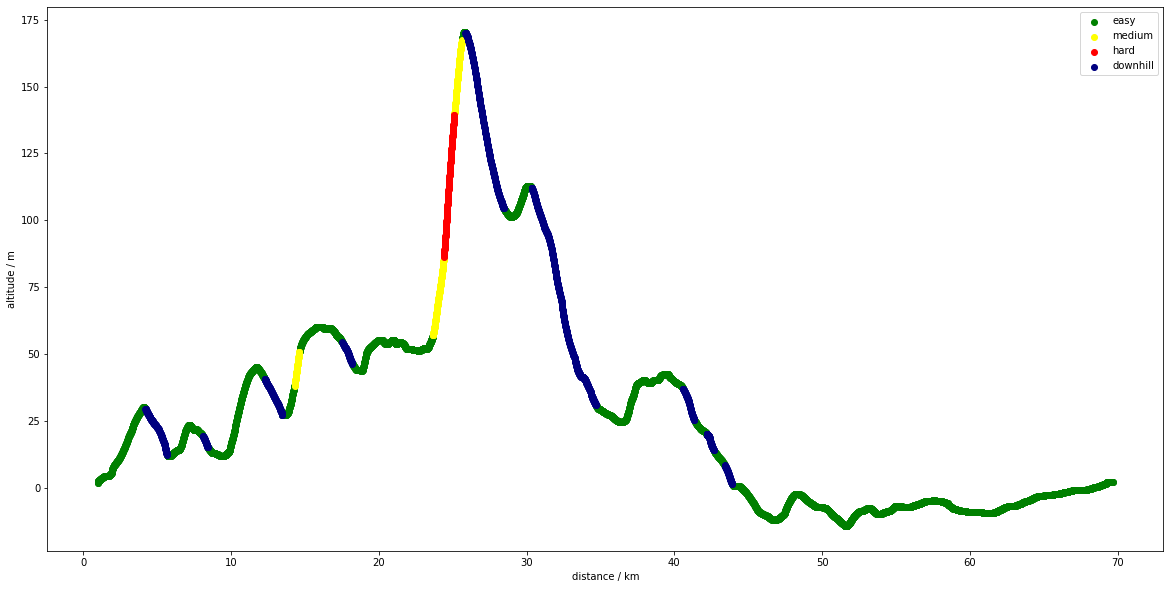

In [12]:
#I spent 5 minutes to correct any outliers, smoothing things out by eye.
#An algo could do this, but this wasn't the goal of the notebook.
smoothed_labels = pd.read_csv('data/smoothed_labels.csv')
df['label'] = smoothed_labels['label']
plot_scatter()
#could also try making a line plot instead after calculating segments - looks neater?

In [13]:
df['label'] = df['label'].fillna('-999')
segment = []; segment.append(0)
for i in range(len(df) - 1):
    current_segment = segment[len(segment) - 1]
    segment.append(current_segment) if df.iloc[i+1]['label'] == df.iloc[i]['label'] else segment.append(current_segment + 1)
df['segment'] = segment

In [14]:
df.iloc[1].segment

0

In [15]:
df.iloc[1234].segment #etc.

5

In [16]:
m = folium.Map(location=[np.mean(df['lat']), np.mean(df['lng'])], zoom_start=10)

for i in range(1, max(segment)):
    df_ = df[df['segment'] == i]
    plot_folium_polyline(df_, plot_color[df_.iloc[0]['label']])
    
#append beginning/end of activity that we chopped when we calculated grade
df_ = df[df['segment'] == 0]
plot_folium_polyline(df_, 'black')
df_ = df[df['segment'] == max(segment)]
plot_folium_polyline(df_, 'black')

#give an indication of where we start and end the ride, otherwise the map is harder to interpret
folium.Marker((df.iloc[0]['lat'], df.iloc[0]['lng']), 
              icon=folium.Icon(color='darkblue', icon_color='white', icon='play')).add_to(m)
folium.Marker((df.iloc[len(df)-1]['lat'], df.iloc[len(df)-1]['lng']), 
              icon=folium.Icon(color='darkblue', icon_color='white', icon='stop')).add_to(m)

m

### use https://nbviewer.jupyter.org/github/thomashoddinott/ipython-notebooks/blob/master/strava-gis-exploration/nb.ipynb?flush_cache=true to see the rendered map if viewing from github.

In [17]:
plot_color #would be cool if this could be shown as a legend on the map above

{'easy': 'green', 'medium': 'yellow', 'hard': 'red', 'downhill': 'navy'}